In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn.compose import ColumnTransformer 
import copy
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
#from sqlalchemy import create_engine
from sklearn.metrics import confusion_matrix, classification_report
import string
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# import torchvision.transforms as transforms
# import torchvision.datasets as dsets
from sklearn.decomposition import PCA,TruncatedSVD, IncrementalPCA
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error as MSE 

In [29]:
df = pd.read_csv("train.xls")

In [30]:
df

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
0,1,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,7981,5.5512,2018-01-01,77095,Texas,2018-01-01
1,2,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,6334,13.3650,2018-01-01,48185,Michigan,2018-01-01
2,3,Westland,0.0,14.730,3,Central,qexty,Consumer,shorts,Standard Class,6333,4.8609,2018-01-01,48185,Michigan,2018-01-01
3,4,Westland,0.0,43.920,3,Central,kariox,Consumer,television,Standard Class,6332,12.7368,2018-01-01,48185,Michigan,2018-01-01
4,5,Westland,0.0,66.580,2,Central,kariox,Consumer,laptop,Standard Class,6331,15.9792,2018-01-01,48185,Michigan,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,6696,Burlington,0.0,542.940,3,East,kariox,Consumer,battery,Standard Class,9389,152.0232,2021-01-01,5408,Vermont,2021-01-01
6696,6697,San Jose,0.2,276.784,2,West,kariox,Corporate,headset,Standard Class,9597,89.9548,2021-01-01,95123,California,2021-01-01
6697,6698,Burlington,0.0,2.040,1,East,kariox,Consumer,watch,Standard Class,9390,0.9588,2021-01-01,5408,Vermont,2021-01-01
6698,6699,New York City,0.1,207.846,3,East,qexty,Corporate,tshirts,Second Class,440,2.3094,2021-01-01,10024,New York,2021-01-01


In [31]:
df_diff = df.loc[df['delivery date'] != df['placement date']] 
df_diff

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
21,22,Mission Viejo,0.15,290.666,2,West,qexty,Consumer,pants,First Class,3366,3.4196,2018-02-01,92691,California,2018-01-01
22,23,Detroit,0.00,229.940,2,Central,kariox,Consumer,laptop,Standard Class,6389,6.8982,2018-02-01,48234,Michigan,2018-01-01
23,24,Detroit,0.00,10.560,2,Central,kariox,Consumer,phone,Standard Class,6388,4.7520,2018-02-01,48234,Michigan,2018-01-01
24,25,New York City,0.20,3.928,1,East,kariox,Consumer,headset,Standard Class,3084,1.3257,2018-02-01,10024,New York,2018-01-01
25,26,San Diego,0.00,36.440,4,West,kariox,Consumer,television,Standard Class,3797,12.0252,2018-02-01,92037,California,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6483,6484,Phoenix,0.20,100.800,2,West,fynota,Corporate,chocolates,Standard Class,6803,21.4200,2021-01-01,85023,Arizona,2020-12-01
6484,6485,Phoenix,0.20,45.120,3,West,fynota,Corporate,chocolates,Standard Class,6802,-7.8960,2021-01-01,85023,Arizona,2020-12-01
6485,6486,Phoenix,0.70,269.970,2,West,fynota,Corporate,sweets,Standard Class,6801,-386.9570,2021-01-01,85023,Arizona,2020-12-01
6486,6487,Phoenix,0.50,35.445,1,West,qexty,Corporate,hoodies,Standard Class,6800,-24.1026,2021-01-01,85023,Arizona,2020-12-01


In [32]:
s = "2018-02-01"
t = "2019-02-01"

int(s.split("-")[0]) - int(t.split("-")[0])

-1

In [33]:
s = s.split("-")
year = []
month = []
delay = []
for i in range(df.shape[0]):
    s = df.iloc[i]['delivery date']
    t = df.iloc[i]['placement date']
    if int(s.split("-")[0]) - int(t.split("-")[0]) == 1:
        delay.append(1)
    else:
        delay.append(int(s.split("-")[1]) - int(t.split("-")[1]))
    
    print(s)
    year.append(int(s.split("-")[0]))
    month.append(int(s.split("-")[1]))
    
df['year'] = year
df['month'] = month
df['delay'] = delay
# df['month'] = df['delivery date'].split("-")[1]
# df.loc[df['delivery date'].split("-")[1]]

2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-02-01
2018-02-01
2018-02-01
2018-02-01
2018-02-01
2018-02-01
2018-02-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-01-01
2018-02-01
2018-02-01
2018-02-01
2018-02-01
2018-02-01
2018-02-01
2018-02-01
2018-02-01
2018-02-01
2018-02-01
2018-03-01
2018-02-01

In [34]:
df

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date,year,month,delay
0,1,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,7981,5.5512,2018-01-01,77095,Texas,2018-01-01,2018,1,0
1,2,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,6334,13.3650,2018-01-01,48185,Michigan,2018-01-01,2018,1,0
2,3,Westland,0.0,14.730,3,Central,qexty,Consumer,shorts,Standard Class,6333,4.8609,2018-01-01,48185,Michigan,2018-01-01,2018,1,0
3,4,Westland,0.0,43.920,3,Central,kariox,Consumer,television,Standard Class,6332,12.7368,2018-01-01,48185,Michigan,2018-01-01,2018,1,0
4,5,Westland,0.0,66.580,2,Central,kariox,Consumer,laptop,Standard Class,6331,15.9792,2018-01-01,48185,Michigan,2018-01-01,2018,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,6696,Burlington,0.0,542.940,3,East,kariox,Consumer,battery,Standard Class,9389,152.0232,2021-01-01,5408,Vermont,2021-01-01,2021,1,0
6696,6697,San Jose,0.2,276.784,2,West,kariox,Corporate,headset,Standard Class,9597,89.9548,2021-01-01,95123,California,2021-01-01,2021,1,0
6697,6698,Burlington,0.0,2.040,1,East,kariox,Consumer,watch,Standard Class,9390,0.9588,2021-01-01,5408,Vermont,2021-01-01,2021,1,0
6698,6699,New York City,0.1,207.846,3,East,qexty,Corporate,tshirts,Second Class,440,2.3094,2021-01-01,10024,New York,2021-01-01,2021,1,0


In [35]:
df.to_csv("mod_train.csv")

In [36]:
df['class'].value_counts()

kariox    4034
qexty     1437
fynota    1229
Name: class, dtype: int64

In [37]:
df['segment'].value_counts()  # -> segment, class- wise avg profit

Consumer       3523
Corporate      2048
Home Office    1129
Name: segment, dtype: int64

In [7]:
df['sub-class'].value_counts()

headset       1025
phone          913
shorts         641
colddrinks     597
laptop         559
television     513
chocolates     502
tshirts        428
battery        303
tablet         250
hoodies        216
watch          185
lighting       155
pants          152
charger        131
sweets          83
fastfood        47
Name: sub-class, dtype: int64

In [8]:

# create columns for month, year, delay
# area specific discount rate
# divide states into categories
# base price of each item
# discount adjusted 
# discount vs profit


In [9]:
df['departure state'].value_counts()  

California              1339
New York                 777
Texas                    668
Pennsylvania             390
Illinois                 323
Ohio                     307
Washington               296
Florida                  255
Michigan                 192
Virginia                 181
North Carolina           164
Arizona                  156
Georgia                  123
Colorado                 121
Tennessee                102
Massachusetts             96
Oregon                    94
Kentucky                  88
Indiana                   88
New Jersey                87
Wisconsin                 77
Delaware                  77
Maryland                  68
Minnesota                 51
Oklahoma                  49
Connecticut               48
Alabama                   45
Arkansas                  41
Mississippi               40
Missouri                  40
Utah                      38
Rhode Island              35
South Carolina            34
Nevada                    31
Louisiana     

In [17]:
df['departure city'].value_counts()

New York City    610
Los Angeles      538
Philadelphia     355
San Francisco    319
Houston          273
                ... 
New Bedford        1
Normal             1
Moorhead           1
Garland            1
Layton             1
Name: departure city, Length: 469, dtype: int64

In [18]:
df['address code'].value_counts()

10035    174
10024    158
10009    148
94122    133
10011    130
        ... 
95695      1
68701      1
76706      1
42104      1
71854      1
Name: address code, Length: 562, dtype: int64

In [19]:
df['delivery date'].value_counts()

2020-12-01    360
2020-09-01    359
2020-11-01    352
2019-12-01    334
2018-11-01    313
2019-11-01    307
2019-09-01    289
2018-12-01    254
2018-09-01    248
2020-06-01    236
2020-10-01    207
2020-07-01    202
2020-04-01    180
2020-05-01    174
2018-10-01    169
2019-10-01    167
2019-06-01    156
2020-08-01    155
2018-07-01    151
2019-07-01    149
2020-03-01    149
2018-08-01    149
2019-04-01    146
2019-08-01    143
2018-03-01    141
2019-05-01    141
2018-04-01    135
2018-06-01    132
2019-03-01    131
2018-05-01    126
2019-01-01    104
2020-01-01     99
2020-02-01     92
2018-01-01     72
2021-01-01     64
2019-02-01     64
2018-02-01     50
Name: delivery date, dtype: int64

In [20]:
df['placement date'].value_counts()

2020-11-01    373
2020-09-01    362
2020-12-01    350
2019-11-01    324
2018-11-01    318
2019-12-01    316
2019-09-01    293
2018-12-01    278
2018-09-01    268
2020-05-01    222
2020-06-01    202
2020-07-01    199
2020-10-01    190
2020-08-01    180
2020-04-01    170
2019-10-01    166
2020-03-01    161
2019-04-01    160
2018-10-01    159
2019-08-01    159
2018-03-01    157
2018-08-01    153
2019-05-01    146
2018-07-01    143
2019-07-01    140
2019-06-01    138
2019-03-01    138
2018-06-01    135
2018-04-01    135
2018-05-01    122
2020-01-01     89
2020-02-01     82
2018-01-01     79
2019-02-01     64
2019-01-01     58
2018-02-01     46
2021-01-01     25
Name: placement date, dtype: int64

In [38]:
d_hoodie = df.loc[df['sub-class']=="hoodies"]
d_hoodie

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date,year,month,delay
26,27,San Diego,0.2,333.000,3,West,qexty,Consumer,hoodies,Standard Class,3796,-16.6500,2018-02-01,92037,California,2018-01-01,2018,2,1
119,120,Chesapeake,0.0,1256.220,6,South,qexty,Consumer,hoodies,Standard Class,5632,75.3732,2018-02-01,23320,Virginia,2018-02-01,2018,2,0
184,185,Springfield,0.4,330.588,1,East,qexty,Home Office,hoodies,Standard Class,9900,-143.2548,2018-04-01,45503,Ohio,2018-03-01,2018,4,1
192,193,Plano,0.3,890.841,3,Central,qexty,Consumer,hoodies,Standard Class,7306,-152.7156,2018-04-01,75023,Texas,2018-03-01,2018,4,1
199,200,Des Moines,0.0,1184.720,4,Central,qexty,Consumer,hoodies,Standard Class,7841,106.6248,2018-04-01,50315,Iowa,2018-03-01,2018,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6605,6606,Springfield,0.0,1056.860,7,South,qexty,Consumer,hoodies,First Class,8555,158.5290,2020-12-01,22153,Virginia,2020-12-01,2020,12,0
6621,6622,Columbus,0.4,328.590,3,East,qexty,Corporate,hoodies,Same Day,5998,-147.8655,2020-12-01,43229,Ohio,2020-12-01,2020,12,0
6659,6660,Franklin,0.4,79.974,3,South,qexty,Corporate,hoodies,Second Class,3258,-29.3238,2020-12-01,37064,Tennessee,2020-12-01,2020,12,0
6674,6675,San Francisco,0.2,1421.664,6,West,qexty,Corporate,hoodies,Standard Class,3481,-195.4788,2020-12-01,94110,California,2020-12-01,2020,12,0


In [ ]:
# observations 

# with discount profit decreases

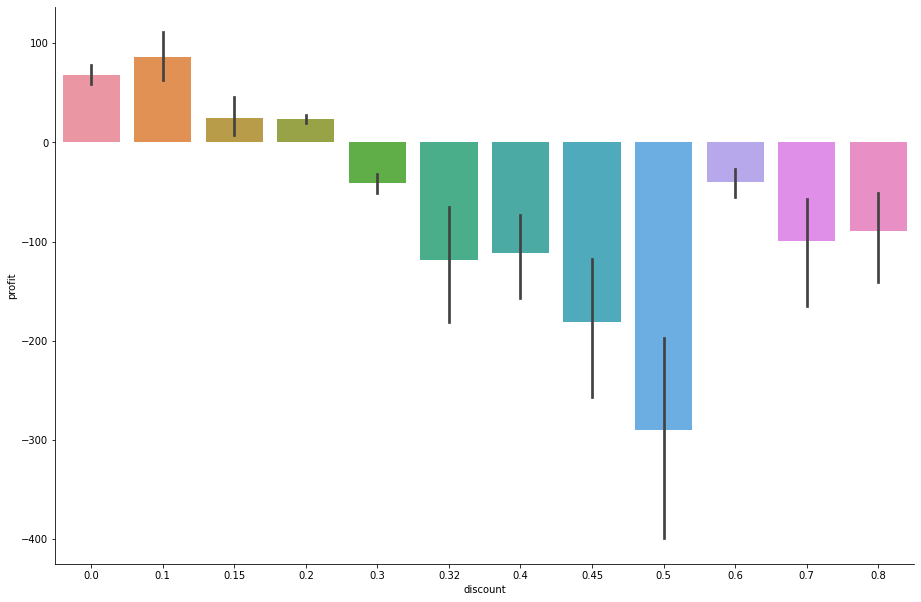

In [50]:
sns.catplot(y="profit", x="discount", kind="bar", data=df,height=8.27, aspect=12.7/8.27)

In [48]:
df['discount'].value_counts()

0.00    3220
0.20    2437
0.70     281
0.80     193
0.30     159
0.40     137
0.60      99
0.10      68
0.50      47
0.15      36
0.32      16
0.45       7
Name: discount, dtype: int64

In [51]:
df_hg_disc = df[df['discount'] >= 0.3]

In [52]:
df_hg_disc['sub-class'].value_counts()

headset       409
hoodies       118
tshirts       111
shorts         99
colddrinks     69
pants          47
battery        40
sweets         39
fastfood        7
Name: sub-class, dtype: int64

In [53]:
df['sub-class'].value_counts()

headset       1025
phone          913
shorts         641
colddrinks     597
laptop         559
television     513
chocolates     502
tshirts        428
battery        303
tablet         250
hoodies        216
watch          185
lighting       155
pants          152
charger        131
sweets          83
fastfood        47
Name: sub-class, dtype: int64

In [64]:
df_profit = df[df['profit'] >= 0]
df.shape

(6700, 19)

In [66]:
print(df_profit['discount'].value_counts())
print(df['discount'].value_counts())

0.00    3220
0.20    2105
0.10      66
0.15      24
0.30      18
0.40      16
Name: discount, dtype: int64
0.00    3220
0.20    2437
0.70     281
0.80     193
0.30     159
0.40     137
0.60      99
0.10      68
0.50      47
0.15      36
0.32      16
0.45       7
Name: discount, dtype: int64


In [56]:
df_profit_high_disc = df_profit[df_profit['discount'] >= 0.3]

In [57]:
df_profit_high_disc

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date,year,month,delay
264,265,Chicago,0.3,574.910,2,Central,fynota,Home Office,sweets,First Class,9406,156.0470,2018-03-01,60653,Illinois,2018-03-01,2018,3,0
297,298,Philadelphia,0.4,71.928,12,East,fynota,Corporate,colddrinks,Second Class,344,8.3916,2018-04-01,19140,Pennsylvania,2018-04-01,2018,4,0
481,482,Philadelphia,0.4,1799.970,5,East,fynota,Consumer,fastfood,First Class,8800,239.9960,2018-05-01,19134,Pennsylvania,2018-05-01,2018,5,0
921,922,Texas City,0.3,489.230,2,Central,qexty,Consumer,hoodies,Standard Class,8894,41.9340,2018-08-01,77590,Texas,2018-08-01,2018,8,0
1160,1161,Philadelphia,0.4,32.382,3,East,fynota,Corporate,colddrinks,Standard Class,1680,4.3176,2018-09-01,19134,Pennsylvania,2018-09-01,2018,9,0
1895,1896,Columbus,0.4,659.988,2,East,fynota,Consumer,fastfood,Second Class,4492,109.9980,2018-12-01,43229,Ohio,2018-12-01,2018,12,0
1971,1972,Philadelphia,0.4,1079.976,4,East,fynota,Consumer,fastfood,Standard Class,8124,125.9972,2018-12-01,19134,Pennsylvania,2018-12-01,2018,12,0
2003,2004,Toledo,0.4,26.376,4,East,fynota,Corporate,colddrinks,Standard Class,9799,2.6376,2019-01-01,43615,Ohio,2019-01-01,2019,1,0
2834,2835,Philadelphia,0.4,269.982,3,East,fynota,Consumer,colddrinks,Second Class,3782,40.4973,2019-07-01,19120,Pennsylvania,2019-07-01,2019,7,0
2902,2903,Bowling Green,0.4,26.982,3,East,fynota,Consumer,colddrinks,Second Class,9517,4.0473,2019-08-01,43402,Ohio,2019-08-01,2019,8,0


In [72]:
df_loss = df[df["profit"] < 0]
df_loss.loc[df['discount'] == 0.60]['sub-class'].value_counts()

shorts    99
Name: sub-class, dtype: int64

In [65]:
df_loss['discount'].value_counts()

0.20    332
0.70    281
0.80    193
0.30    141
0.40    121
0.60     99
0.50     47
0.32     16
0.15     12
0.45      7
0.10      2
Name: discount, dtype: int64

In [67]:
df_no_disc_loss = df[(df["profit"] < 0) and (df['discount'] == 0.20)]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [83]:
sc = df['sub-class'].unique()
for i in range(len(sc)):
    ndf = df[df['sub-class'] == sc[i]]
    

array(['phone', 'headset', 'shorts', 'television', 'laptop', 'battery',
       'tshirts', 'watch', 'colddrinks', 'pants', 'lighting', 'hoodies',
       'chocolates', 'tablet', 'charger', 'sweets', 'fastfood'],
      dtype=object)

In [ ]:
# every sub class has different profit range. Some are extremely high profit earning some are extremely low or negative 
# profit depends highly on discount. out of 7000 data points only 21 points are having profit > 0 and discount > 0.2
# no item with zero discount and loss


# sub-class, discount, price are the most important columns

### column price is the "Price of single commodity"   (derived from the fact that loss or profit in some of the columns is even more than the value in price column)

In [ ]:
sns.catplot(y="profit", x="discount", kind="bar", data=df,height=8.27, aspect=12.7/8.27)

In [40]:
import seaborn as sns

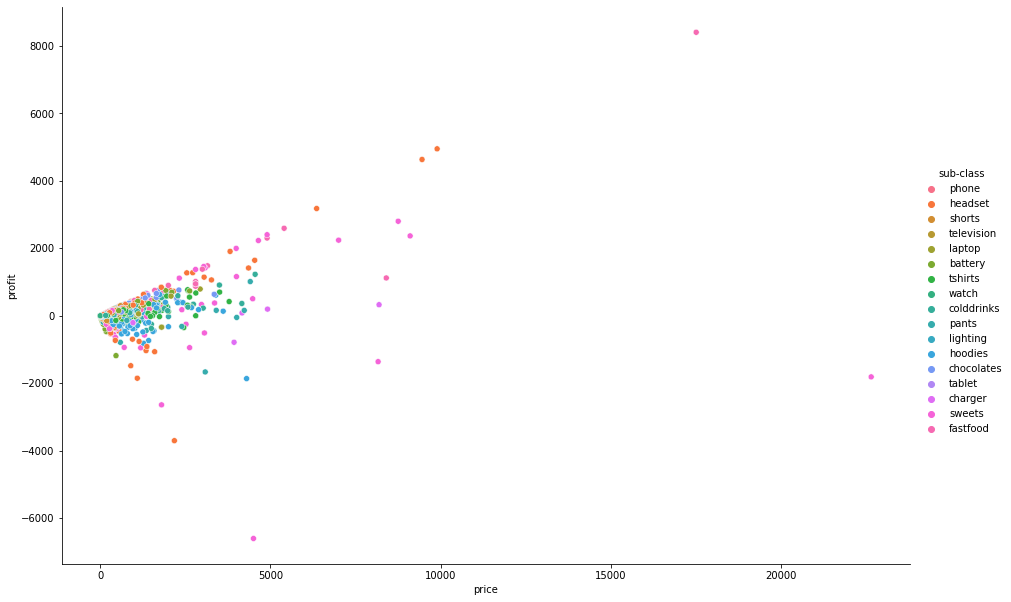

In [77]:
sns.relplot(
    data=df,
    x="price", y="profit",
    hue="sub-class",height=8.27, aspect=12.7/8.27
)


In [79]:
df[abs(df['profit']) > df['price']]

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date,year,month,delay
16,17,Scottsdale,0.7,181.470,5,West,qexty,Consumer,pants,First Class,5466,-320.5970,2018-01-01,85254,Arizona,2018-01-01,2018,1,0
43,44,Huntsville,0.8,10.430,7,Central,kariox,Consumer,headset,Standard Class,7662,-18.2525,2018-01-01,77340,Texas,2018-01-01,2018,1,0
55,56,Naperville,0.8,3.540,2,Central,kariox,Home Office,headset,Standard Class,742,-5.4870,2018-01-01,60540,Illinois,2018-01-01,2018,1,0
80,81,Dallas,0.8,7.960,2,Central,kariox,Consumer,battery,Standard Class,1334,-13.9300,2018-02-01,75220,Texas,2018-02-01,2018,2,0
81,82,Dallas,0.8,1.080,3,Central,kariox,Consumer,headset,Standard Class,1333,-1.7280,2018-02-01,75220,Texas,2018-02-01,2018,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6396,6397,Chicago,0.8,4.788,3,Central,kariox,Consumer,headset,Second Class,470,-7.9002,2020-12-01,60610,Illinois,2020-12-01,2020,12,0
6444,6445,Deer Park,0.8,6.924,6,Central,kariox,Corporate,headset,First Class,4139,-10.3860,2021-01-01,77536,Texas,2020-12-01,2021,1,1
6485,6486,Phoenix,0.7,269.970,2,West,fynota,Corporate,sweets,Standard Class,6801,-386.9570,2021-01-01,85023,Arizona,2020-12-01,2021,1,1
6548,6549,San Angelo,0.8,11.648,4,Central,kariox,Consumer,battery,Second Class,8113,-30.8672,2020-12-01,76903,Texas,2020-12-01,2020,12,0


In [78]:
abs(-2)

2

In [63]:
#df_arr = df.to_numpy()
#print(df_arr)

df_cp = df.copy()


df_darr = df_cp.drop(['id','departure city','location','class','RID','departure state','delivery date','placement date','segment','delivery type','address code'],axis=1)
print(df_darr)

      discount    price  no of items   sub-class    profit
0          0.2   16.448            2       phone    5.5512
1          0.0   29.700            5     headset   13.3650
2          0.0   14.730            3      shorts    4.8609
3          0.0   43.920            3  television   12.7368
4          0.0   66.580            2      laptop   15.9792
...        ...      ...          ...         ...       ...
6695       0.0  542.940            3     battery  152.0232
6696       0.2  276.784            2     headset   89.9548
6697       0.0    2.040            1       watch    0.9588
6698       0.1  207.846            3     tshirts    2.3094
6699       0.2  160.776            3  colddrinks   10.0485

[6700 rows x 5 columns]


In [64]:
df_arr = df_darr.to_numpy()
df_arr            # discount, price, no. items, segment, sub-class, del.type, profit, address code

array([[0.2, 16.448, 2, 'phone', 5.5512],
       [0.0, 29.7, 5, 'headset', 13.365],
       [0.0, 14.73, 3, 'shorts', 4.8609],
       ...,
       [0.0, 2.04, 1, 'watch', 0.9588],
       [0.1, 207.84599999999998, 3, 'tshirts', 2.3094],
       [0.2, 160.776, 3, 'colddrinks', 10.0485]], dtype=object)

In [49]:
#experimenting

# One hot encoding
enc = onehot(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ['Female', 2]]
#enc.fit(df_arr[:,5:7],)
enc.fit(X)
print(enc.categories_)
#val = enc.transform([['Standard Class', 1], ['Second Class', 4]]).toarray()
#print(val)

[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]


In [65]:
delt = np.reshape(np.array(df_arr[:,3],dtype=np.str),(-1,1))

In [66]:
enc.fit(delt)
print(enc.categories_)
val = enc.transform(delt).toarray()
print(val)

[array(['battery', 'charger', 'chocolates', 'colddrinks', 'fastfood',
       'headset', 'hoodies', 'laptop', 'lighting', 'pants', 'phone',
       'shorts', 'sweets', 'tablet', 'television', 'tshirts', 'watch'],
      dtype='<U10')]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [74]:
up_arr = np.concatenate((df_arr[:,:3],val[:]),axis=1)
print(up_arr)
pr_arr = df_arr[:,4]
print(pr_arr)

[[0.2 16.448 2 ... 0.0 0.0 0.0]
 [0.0 29.7 5 ... 0.0 0.0 0.0]
 [0.0 14.73 3 ... 0.0 0.0 0.0]
 ...
 [0.0 2.04 1 ... 0.0 0.0 1.0]
 [0.1 207.84599999999998 3 ... 0.0 1.0 0.0]
 [0.2 160.776 3 ... 0.0 0.0 0.0]]
[5.5512 13.365 4.8609 ... 0.9588 2.3094 10.0485]


In [105]:
train_X, test_X, train_y, test_y = train_test_split(up_arr, pr_arr, 
                      test_size = 0.3, random_state = 123) 
  
# Instantiation 
xgb_r = xgb.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 100, learning_rate = 0.01, max_depth = 10, seed = 123) 

In [106]:
xgb_r.fit(train_X, train_y) 
  
# Predict the model 
pred = xgb_r.predict(test_X) 
  
# RMSE Computation 
#zr = np.zeros()
rmse = 1 - np.sum((pred-test_y)*(pred-test_y))/(np.sum(test_y*test_y)) 
print("RMSE : % f" %(rmse)) 

[01:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  0.681830


In [108]:
df1 = pd.read_csv("test.xls")
df1

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,delivery date,address code,departure state,placement date
0,6701,San Francisco,0.0,24.200,5,West,kariox,Consumer,television,Standard Class,2408,2021-01-01,94122,California,2021-01-01
1,6702,San Francisco,0.2,359.976,3,West,fynota,Consumer,colddrinks,Standard Class,2409,2021-01-01,94122,California,2021-01-01
2,6703,Waterbury,0.0,3.520,2,East,kariox,Consumer,television,Standard Class,5425,2021-01-01,6708,Connecticut,2021-01-01
3,6704,Chicago,0.2,11.520,5,Central,kariox,Consumer,tablet,First Class,7408,2021-01-01,60653,Illinois,2021-01-01
4,6705,Seattle,0.0,242.940,3,West,kariox,Home Office,laptop,Standard Class,733,2021-01-01,98115,Washington,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3289,9990,New York City,0.0,31.920,4,East,kariox,Consumer,laptop,Second Class,1171,2021-12-01,10035,New York,2021-12-01
3290,9991,New York City,0.0,19.440,3,East,kariox,Consumer,phone,Second Class,1170,2021-12-01,10035,New York,2021-12-01
3291,9992,New York City,0.0,272.940,3,East,kariox,Consumer,laptop,Second Class,1169,2021-12-01,10035,New York,2021-12-01
3292,9993,San Francisco,0.2,113.568,2,West,qexty,Consumer,tshirts,Standard Class,414,2021-12-01,94110,California,2021-12-01


In [109]:
df_test = df1.drop(['id','departure city','location','class','RID','departure state','delivery date','placement date','segment','delivery type','address code'],axis=1)


In [110]:
df_test

,discount,price,no of items,sub-class
0,0.0,24.200,5,television
1,0.2,359.976,3,colddrinks
2,0.0,3.520,2,television
3,0.2,11.520,5,tablet
4,0.0,242.940,3,laptop
...,...,...,...,...
3289,0.0,31.920,4,laptop
3290,0.0,19.440,3,phone
3291,0.0,272.940,3,laptop
3292,0.2,113.568,2,tshirts


In [112]:
test_arr = df_test.to_numpy()
test_arr

array([[0.0, 24.2, 5, 'television'],
       [0.2, 359.976, 3, 'colddrinks'],
       [0.0, 3.52, 2, 'television'],
       ...,
       [0.0, 272.94, 3, 'laptop'],
       [0.2, 113.568, 2, 'tshirts'],
       [0.2, 3.0239999999999996, 3, 'lighting']], dtype=object)

In [113]:
subt = np.reshape(test_arr[:,3],(-1,1))

subtr = enc.transform(subt).toarray()
subtr

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [117]:
up_test = np.concatenate((test_arr[:,:3],subtr),axis=1)
up_test

array([[0.0, 24.2, 5, ..., 1.0, 0.0, 0.0],
       [0.2, 359.976, 3, ..., 0.0, 0.0, 0.0],
       [0.0, 3.52, 2, ..., 1.0, 0.0, 0.0],
       ...,
       [0.0, 272.94, 3, ..., 0.0, 0.0, 0.0],
       [0.2, 113.568, 2, ..., 0.0, 1.0, 0.0],
       [0.2, 3.0239999999999996, 3, ..., 0.0, 0.0, 0.0]], dtype=object)

In [118]:
pred_test = xgb_r.predict(up_test)
pred_test

array([ 5.367894 , 23.109272 ,  1.7790574, ..., 26.623896 ,  9.536796 ,
        1.6284914], dtype=float32)

In [119]:
len(pred_test)

3294

In [120]:
sub = pd.DataFrame()

In [121]:
sub['profit'] = pred_test

In [123]:
sub.to_csv('/home/profit_file.csv')

In [21]:
print(df.columns)
len(df.columns)

Index(['id', 'departure city', 'discount', 'price', 'no of items', 'location',
       'class', 'segment', 'sub-class', 'delivery type', 'RID', 'profit',
       'delivery date', 'address code', 'departure state', 'placement date'],
      dtype='object')


16

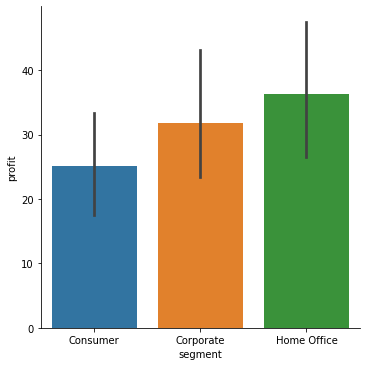

In [23]:
import seaborn as sns
sns.catplot(x="segment", y="profit", kind="bar", data=df)

In [54]:
df['no of items'].value_counts()

3     1656
2     1625
4      794
5      792
1      565
7      415
6      401
9      178
8      158
10      39
11      21
14      21
13      19
12      16
Name: no of items, dtype: int64

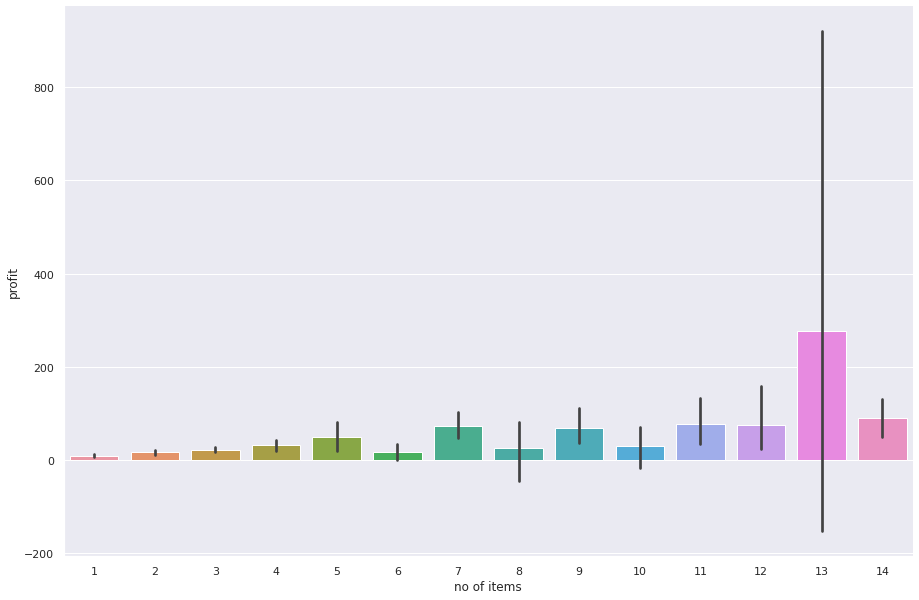

In [52]:
import seaborn as sns
sns.catplot(y="profit", x="no of items", kind="bar", data=df,height=8.27, aspect=12.7/8.27)

In [58]:
187.98 - 155.35 

32.629999999999995

In [69]:


df_cd = df.loc[df['sub-class'] == 'colddrinks']  #155.30
df_cd_Ca = df_cd.loc[df_cd['departure state'] == 'California']
df_cd_Ca[df_cd_Ca['address code'] == 90008]

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
446,447,Los Angeles,0.2,83.984,2,West,fynota,Corporate,colddrinks,Standard Class,1613,31.4940,2018-05-01,90008,California,2018-05-01
471,472,Los Angeles,0.2,201.584,2,West,fynota,Corporate,colddrinks,Standard Class,1612,20.1584,2018-05-01,90008,California,2018-05-01
1449,1450,Los Angeles,0.2,79.968,4,West,fynota,Corporate,colddrinks,First Class,8709,-17.9928,2018-11-01,90008,California,2018-11-01
1802,1803,Los Angeles,0.2,211.168,4,West,fynota,Corporate,colddrinks,First Class,8796,15.8376,2018-12-01,90008,California,2018-12-01
1852,1853,Los Angeles,0.2,583.800,5,West,fynota,Corporate,colddrinks,First Class,8795,72.9750,2018-12-01,90008,California,2018-12-01
2290,2291,Los Angeles,0.2,88.776,3,West,fynota,Consumer,colddrinks,Standard Class,6293,7.7679,2019-04-01,90008,California,2019-04-01
2506,2507,Los Angeles,0.2,88.752,3,West,fynota,Corporate,colddrinks,Standard Class,1450,11.0940,2019-05-01,90008,California,2019-05-01
3408,3409,Los Angeles,0.2,503.960,5,West,fynota,Consumer,colddrinks,First Class,6955,50.3960,2019-10-01,90008,California,2019-10-01
3692,3693,Los Angeles,0.2,1212.848,7,West,fynota,Home Office,colddrinks,Standard Class,1487,106.1242,2019-11-01,90008,California,2019-11-01
3847,3848,Los Angeles,0.2,135.984,2,West,fynota,Consumer,colddrinks,Second Class,8938,16.9980,2019-12-01,90008,California,2019-12-01


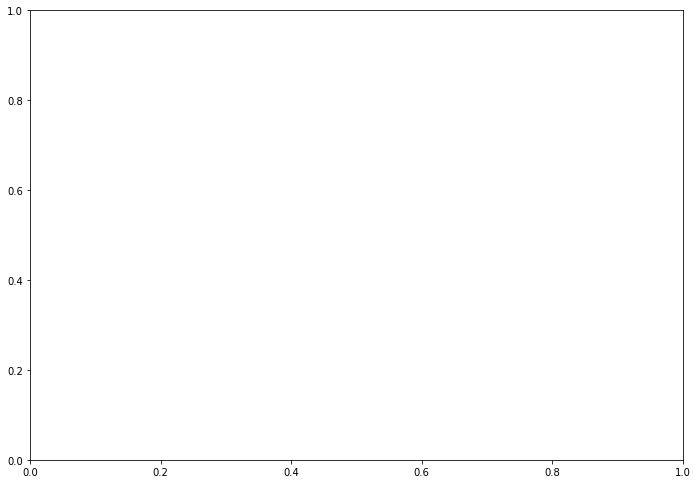

In [34]:
from matplotlib import pyplot
import seaborn

# import mylib

a4_dims = (11.7, 8.27)
# df = mylib.load_data()
fig, ax = pyplot.subplots(figsize=a4_dims)

In [43]:
sns.set(rc={'figure.figsize':(80,60)})

/home/rohit/Desktop/Coneio/nlp/lib/python3.6/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


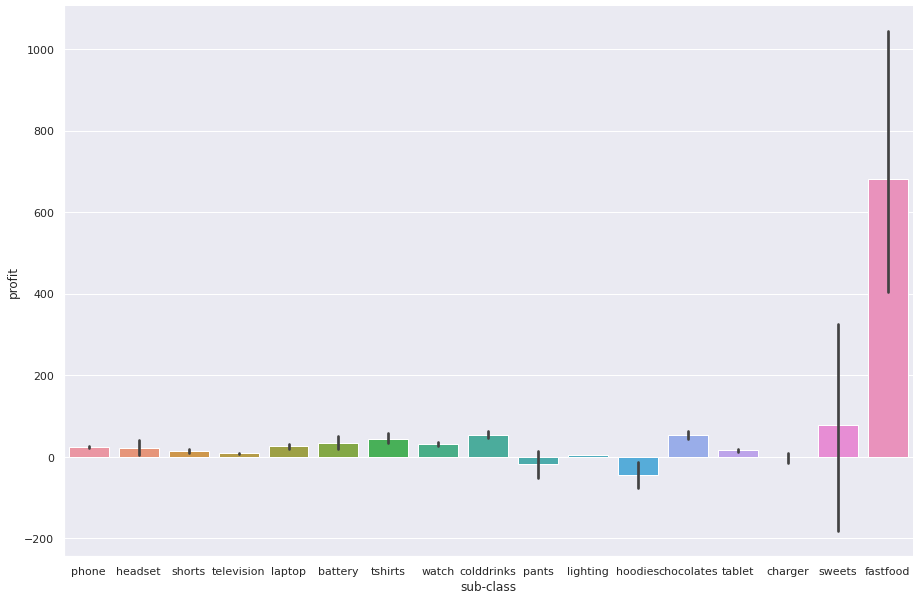

In [48]:
sns.catplot(ax = ax, x="sub-class", y="profit", kind="bar", data=df, height=8.27, aspect=12.7/8.27)

/home/rohit/Desktop/Coneio/nlp/lib/python3.6/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


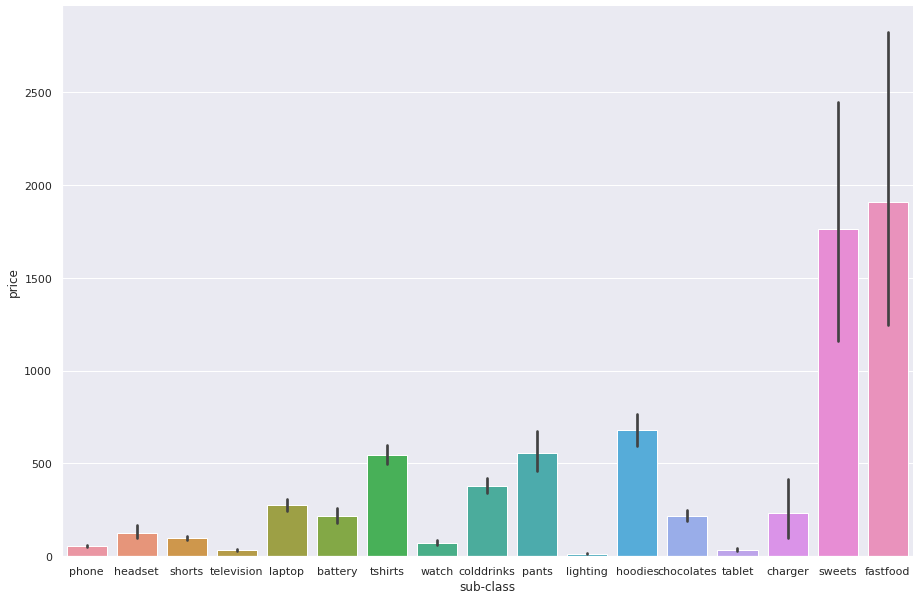

In [49]:
sns.catplot(ax = ax, x="sub-class", y="price", kind="bar", data=df, height=8.27, aspect=12.7/8.27)

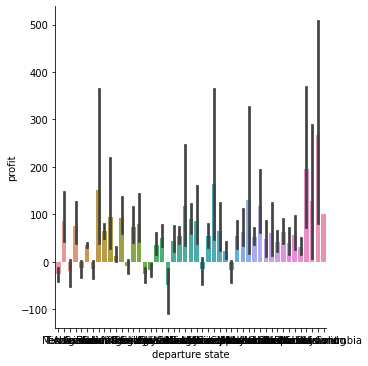

In [21]:
sns.catplot(x="departure state", y="profit", kind="bar", data=df)

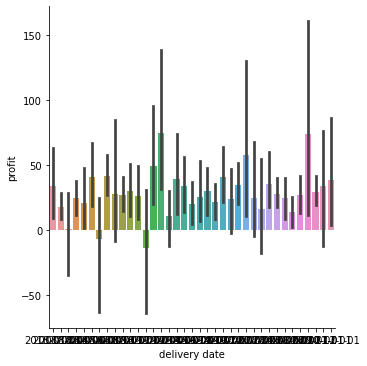

In [31]:
sns.catplot(x="delivery date", y="profit", kind="bar", data=df)

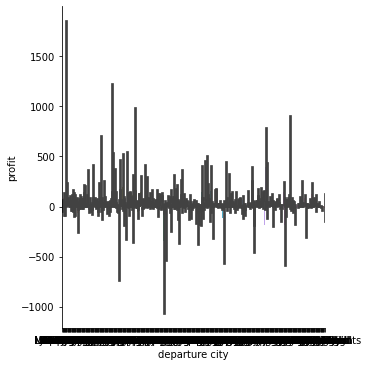

In [24]:
sns.catplot(x="departure city", y="profit", kind="bar", data=df)

In [ ]:
sns.catplot(x="departure city", y="profit", kind="box", data=df)

In [ ]:

#city, code -> 3-4 class

date -> 



In [5]:
df1 = pd.read_csv("test.csv")
df1

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,delivery date,address code,departure state,placement date
0,6701,San Francisco,0.0,24.200,5,West,kariox,Consumer,television,Standard Class,2408,2021-01-01,94122,California,2021-01-01
1,6702,San Francisco,0.2,359.976,3,West,fynota,Consumer,colddrinks,Standard Class,2409,2021-01-01,94122,California,2021-01-01
2,6703,Waterbury,0.0,3.520,2,East,kariox,Consumer,television,Standard Class,5425,2021-01-01,6708,Connecticut,2021-01-01
3,6704,Chicago,0.2,11.520,5,Central,kariox,Consumer,tablet,First Class,7408,2021-01-01,60653,Illinois,2021-01-01
4,6705,Seattle,0.0,242.940,3,West,kariox,Home Office,laptop,Standard Class,733,2021-01-01,98115,Washington,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3289,9990,New York City,0.0,31.920,4,East,kariox,Consumer,laptop,Second Class,1171,2021-12-01,10035,New York,2021-12-01
3290,9991,New York City,0.0,19.440,3,East,kariox,Consumer,phone,Second Class,1170,2021-12-01,10035,New York,2021-12-01
3291,9992,New York City,0.0,272.940,3,East,kariox,Consumer,laptop,Second Class,1169,2021-12-01,10035,New York,2021-12-01
3292,9993,San Francisco,0.2,113.568,2,West,qexty,Consumer,tshirts,Standard Class,414,2021-12-01,94110,California,2021-12-01
